In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
import os
import numpy as np
import math
from tqdm import tqdm
from sklearn import metrics

In [36]:
def make_data(lst, dim):
    lst=pd.DataFrame(lst)
    lst.columns=['data']
    window=dim
    str='data'
    for i in range(1, window):
        column=f'{str}_lag{i}'
        lst[column]=lst[str].shift(i)
    lst=lst.dropna().reset_index(drop=True)
    return lst.values

def calc_leq(df, unit):
    df.reset_index(inplace=True, drop=True)
    for i in range(int(len(df)/unit)+1):
        hour_df=df.loc[i*unit:(i+1)*unit, 'original'].copy()
        N=len(hour_df)
        Leq=10*np.log10(np.sum(np.power(10, hour_df/10)))-10*np.log10(N)
        df.loc[i*unit:(i+1)*unit, 'leq']=Leq
    return df

def leq_filter(df):
    df=calc_leq(df, 18000)
    df.loc[(df['original']<df['leq']), 'd']=0
    return df

def validate(test_v, anorm, thr):
    test_v['z']=np.where(anorm>=thr, 1, 0)
    test_v.reset_index(inplace=True, drop=True)
    
    #     適合率
    tp=test_v[(test_v['label']==1)&(test_v['z']==1)]
    z_p=test_v[test_v['z']==1]
    pre_score=len(tp)/len(z_p)

    #     再現率
    df_anorm=[]
    search= 1 if test_v.loc[0, 'label']==0 else 0
    start=0
    for num in range(len(test_v)):
        if search==1 and test_v.loc[num, 'label']==search:
            start=num
            search=0
        elif search==0 and test_v.loc[num, 'label']==search:
            stop=num-1
            anorm_range=test_v.loc[start:stop].copy()
            df_anorm.append(anorm_range)
            search=1
            
    count=[]
    for i in range(len(df_anorm)):
        if len(df_anorm[i].loc[df_anorm[i]['z']==1])>=1:
               count.append(i)    

    re_score=len(count)/len(df_anorm)

    return pre_score, re_score

def figure(df_test, anorm, d, thr):
    df_test['z']=np.where(d>=thr, 1, 0)
    
    z=df_test['z'].values*100
    test_plot=df_test['original'].values
    num_ax=math.ceil(len(test_plot)/17999)
    label=df_test['label'].values*100
    label_index=range(len(label))
    time_unit=60
    time=[t*0.2/60 for t in range(len(anorm))]
    plt.rcParams["font.size"] = 30

    fig, ax=plt.subplots(num_ax, 1, figsize=(35, 15*num_ax))
    for i in range(num_ax):
        ax[i].plot(time, anorm, '-r',linewidth = 1 )
        ax[i].plot(time, test_plot, '-k',linewidth = 2)
        ax[i].fill_between(time, label, facecolor='lime' )
        ax[i].fill_between(time, z, facecolor='coral' )
        ax[i].set_ylim(0, 90)
        ax[i].set_xlim(i*time_unit, time_unit*(i+1))
        ax[i].set_xticks(np.arange(60*i, 60*(i+1)))
        ax[i].xaxis.set_tick_params(rotation=70)
    plt.show()
    
def fig_pr(test_v, d, bins):
    thr_1=np.linspace(d.min(), 0.3, bins-5)
    thr_2=np.linspace(0.31, d.max(), 5)
    thresholds=np.concatenate([thr_1, thr_2])
    precision=np.array([])
    recall=np.array([])
    for i in thresholds:
        p, r=validate(test_v, d, i)
        precision=np.append(precision, p)
        recall=np.append(recall, r)

    auc = metrics.auc(recall, precision)
    f_score=(2*precision*recall)/(precision+recall)
    thr=thresholds[np.argmax(f_score)]

    plt.rcParams["font.size"] = 10
    plt.plot(recall, precision, marker='o', markevery=[np.argmax(f_score)], label='PR curve (AUC = %.2f)'%auc)
    plt.legend()
    plt.title('PR curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.show()

    return precision, recall, f_score, thresholds, thr, auc
    
def auc_gs(test_v, d, bins):
    thr_1=np.linspace(d.min(), 0.3, bins-5)
    thr_2=np.linspace(0.31, d.max(), 5)
    thresholds=np.concatenate([thr_1, thr_2])
    precision=np.array([])
    recall=np.array([])
    for i in thresholds:
        p, r=validate(test_v, d, i)
        precision=np.append(precision, p)
        recall=np.append(recall, r)

    auc = metrics.auc(recall, precision)

    return auc

def fig_th_f(thresholds, f_score):
    plt.plot(thresholds, f_score, marker="o", markevery=[np.argmax(f_score)])
    plt.xlabel('thresholds')
    plt.ylabel('f_score')
    plt.grid(True)
    plt.show()
    
    return thresholds[np.argmax(f_score)], f_score.max()

In [37]:
df = pd.read_csv( os.path.join('filtered_csv_label', 'learning_data_10.csv') )
df=df[df['day']<=9]

## グリッドサーチ
### 2日目をバリデーションデータとしてチューニング

In [4]:
test_day=[2]
data = df.loc[df['day'].isin(test_day), 'original'].reset_index(drop=True)

In [5]:
w_list=[6, 10, 14, 18, 22, 26]
l_list=[6, 10, 14, 18, 22, 26]
d_list=[6, 10, 14, 18, 22, 26]
best_score=0
for w in tqdm(w_list):
    for l in l_list:
        for d in d_list:
            #それぞれ（テスト、履歴）の直行行列の最初のm列目までを使う
            m = 2
            #データ数
            T = len(data)
            sv = [0 for i in range(0, T)]
            for s in range(l+w-1, T-d, l+w-1):
                H1 = make_data(data[s-w-l+1:s].values, w).T
                Htest = make_data(data[s-w-l+1+d:s+d].values, w).T
                U1 =  np.linalg.svd(H1)[0]
                U2 =  np.linalg.svd(Htest)[0]
                e  =  np.linalg.svd(np.dot(U1[:, 0:m].T , U2[:, 0:m]))[1]
                ab = e[0]
                sv[s] = (1 - ab*ab)
            sv=np.array(sv)
            sv=sv/sv.max()
            test_v=df.loc[df['day'].isin(test_day), ['original', 'label']]
            test_v['d']=sv
            
            #道路交通騒音に埋もれている異常音は正常とする
            test_v=leq_filter(test_v)
            sv=test_v['d'].values
            
            target_v=test_v[l+w-1::l+w-1].copy().reset_index(drop=True)
            target_sv=sv[l+w-1::l+w-1]
            
            #AUC計算
            thr_bins=20
            auc = auc_gs(target_v, target_sv, thr_bins)
            
            if auc>best_score:
                best_score=auc
                best_params={'w':w, 'l':l, 'd':d}
                print(f'更新AUC：{best_score}')
print('==================================================================')
print(f'AUC最高：{best_score}')
print(f'パラメータ：{best_params}')

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

更新AUC：0.30898814806419317
更新AUC：0.4213517608361753
更新AUC：0.42818927028300857
更新AUC：0.5186400538922571
更新AUC：0.5346712641762332


100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [5:48:04<00:00, 3480.79s/it]

AUC最高：0.5346712641762332
パラメータ：{'w': 6, 'l': 22, 'd': 14}


## 評価
### 1日目をテストデータとして

In [6]:
# best_params={'w':10, 'l':6, 'd':6}

In [38]:
test_day=[1]
data = df.loc[df['day'].isin(test_day), 'original'].reset_index(drop=True)

#窓幅（列数）
w =best_params['w']
#行数
l = best_params['l']
#テスト行列と履歴行列をどれだけずらすか
d =best_params['d']
#それぞれ（テスト、履歴）の直行行列の最初のm列目までを使う
m = 2
#データ数
T = len(data)
sv = [0 for i in range(0, T)]

In [ ]:
for s in range(l+w-1, T-d, l+w-1):
    H1 = make_data(data[s-w-l+1:s].values, w).T
    Htest = make_data(data[s-w-l+1+d:s+d].values, w).T
    U1 =  np.linalg.svd(H1)[0]
    U2 =  np.linalg.svd(Htest)[0]
    e  =  np.linalg.svd(np.dot(U1[:, 0:m].T , U2[:, 0:m]))[1]
    print ('e', e)
    ab = e[0]
    sv[s] = (1 - ab*ab)

e [0.99999992 0.99287425]
e [0.99999997 0.04300273]
e [1.         0.79822188]
e [0.99999989 0.09202388]
e [0.99999996 0.95997515]
e [0.99999984 0.99115006]
e [0.99999933 0.97154609]
e [0.99999997 0.99831643]
e [0.99999993 0.98221969]
e [0.99999995 0.66804602]
e [0.99999988 0.97770215]
e [0.99999996 0.4090228 ]
e [0.99999761 0.23957251]
e [0.99999986 0.09476328]
e [1.         0.97972672]
e [0.99999955 0.91645438]
e [0.99999998 0.95530198]
e [0.99999998 0.86241787]
e [0.99999998 0.76443593]
e [0.99999998 0.94483784]
e [0.99999965 0.30497795]
e [0.99999985 0.32463766]
e [0.99999998 0.99447042]
e [0.99999997 0.77284091]
e [1.         0.03465547]
e [0.99999997 0.25405903]
e [1.         0.06451344]
e [0.99999995 0.93148813]
e [0.99999997 0.90676342]
e [0.99999998 0.85943739]
e [1.         0.44384759]
e [0.99999999 0.19215323]
e [0.99999993 0.98125668]
e [0.99999983 0.26182365]
e [0.99999996 0.88791854]
e [0.99999998 0.95507192]
e [0.9999999  0.68573915]
e [0.99999934 0.86485675]
e [0.9999999

e [0.99999991 0.98507973]
e [0.99999995 0.21721293]
e [0.99999966 0.98799403]
e [0.99999984 0.99828196]
e [0.99999998 0.96089493]
e [0.99999973 0.99245378]
e [0.99999998 0.94365635]
e [0.99999984 0.98284176]
e [0.99999936 0.98629487]
e [0.99999999 0.99828262]
e [0.99999881 0.95043598]
e [0.99999995 0.26395493]
e [0.99999996 0.87643528]
e [0.99999986 0.99238196]
e [0.99999981 0.99940749]
e [0.9999999  0.95522511]
e [0.9999992  0.99645605]
e [0.99999978 0.9918457 ]
e [0.9999998  0.99332517]
e [0.99999998 0.26101775]
e [0.99999995 0.99889614]
e [0.99999974 0.87798866]
e [0.99999982 0.99914586]
e [0.99999997 0.99700997]
e [0.99999987 0.98343021]
e [1.         0.60170854]
e [0.99999993 0.46464005]
e [0.99999976 0.99893497]
e [0.99999971 0.94627354]
e [0.99999991 0.99863384]
e [1.        0.0476269]
e [0.99999985 0.9944545 ]
e [0.99999986 0.98736766]
e [0.99999994 0.85879265]
e [0.99999996 0.79420929]
e [1.         0.76062263]
e [0.99999988 0.39451583]
e [0.9999998  0.64595502]
e [0.99999582 

e [0.99999994 0.9923426 ]
e [0.99999955 0.85679058]
e [0.99999995 0.99650278]
e [0.99999999 0.88173677]
e [0.99999829 0.98144043]
e [0.99999814 0.98773415]
e [0.99999996 0.09221117]
e [0.99999991 0.05858822]
e [0.99999999 0.93673114]
e [0.99999998 0.92377329]
e [0.99999904 0.80443711]
e [0.99999972 0.38359115]
e [0.99999991 0.97928351]
e [0.99999999 0.95227164]
e [0.99999984 0.98474137]
e [0.99999991 0.96763167]
e [0.99999974 0.98930938]
e [0.99999998 0.9265821 ]
e [0.99999895 0.85269643]
e [0.99999908 0.94106653]
e [0.99999965 0.98650446]
e [0.9999997 0.9281554]
e [0.99999938 0.97835806]
e [0.99999995 0.99661305]
e [0.99999976 0.93308416]
e [0.99999999 0.76730103]
e [0.99999994 0.40514431]
e [0.99999992 0.98039389]
e [0.99997449 0.98178587]
e [0.99998977 0.81154733]
e [0.99999987 0.4122635 ]
e [0.99998186 0.88372255]
e [0.99995421 0.93834591]
e [0.99999601 0.93718499]
e [0.99999992 0.63539124]
e [0.99999987 0.99713517]
e [0.99999965 0.90685943]
e [0.9999998  0.95941958]
e [0.99982724 

e [0.99999981 0.04546153]
e [0.99999993 0.88201878]
e [0.99999999 0.99687959]
e [0.99999999 0.98176868]
e [0.99999971 0.93775956]
e [0.99999999 0.80502217]
e [0.99999995 0.1397779 ]
e [0.99999989 0.96145704]
e [0.99999994 0.78162366]
e [0.9999996 0.9930968]
e [0.99999887 0.99008048]
e [0.99999993 0.99713464]
e [0.99999998 0.88134597]
e [0.99999997 0.82005536]
e [0.99999998 0.99629354]
e [0.9999999  0.99556238]
e [0.99999979 0.9808753 ]
e [0.99999534 0.98403976]
e [0.99999983 0.96531046]
e [0.99999924 0.92351493]
e [0.99999995 0.00113182]
e [0.99999986 0.3449087 ]
e [0.99999998 0.97365737]
e [0.99999985 0.99123724]
e [0.99999996 0.99252383]
e [0.99999914 0.99796118]
e [0.99999969 0.83355978]
e [0.999999   0.99921573]
e [0.99999975 0.99255388]
e [0.99999931 0.35872449]
e [0.99999979 0.99615429]
e [0.99999975 0.98374621]
e [0.99999968 0.99740696]
e [0.9999999  0.99698212]
e [0.99999961 0.99539591]
e [0.99999999 0.98899802]
e [1.         0.98961471]
e [0.9999998  0.95753543]
e [0.99999996 

e [0.99999972 0.95619427]
e [0.99999981 0.99655375]
e [0.99999997 0.99832297]
e [0.99999999 0.99041615]
e [0.99999958 0.99433291]
e [1.        0.9984272]
e [0.99999998 0.29615369]
e [0.99999998 0.39342654]
e [0.99999997 0.97216366]
e [0.99999998 0.99517824]
e [0.99999981 0.99149948]
e [0.99999995 0.96878379]
e [0.99999984 0.93770164]
e [0.99999999 0.91182775]
e [0.99999938 0.99938279]
e [0.99999986 0.96911912]
e [0.99999998 0.9523208 ]
e [0.99999991 0.99792761]
e [0.99999999 0.93307445]
e [0.9999998  0.99771126]
e [0.99999963 0.98341412]
e [0.99999998 0.95068108]
e [0.99999999 0.97638076]
e [0.99999999 0.71422281]
e [0.99999978 0.99817697]
e [0.99999995 0.99095942]
e [0.99999991 0.98933954]
e [0.99999941 0.99960201]
e [0.9999995  0.90594817]
e [0.99999963 0.99257088]
e [0.99999985 0.98165922]
e [0.99999993 0.99252608]
e [0.99999995 0.99224826]
e [0.99999999 0.99685481]
e [0.99999988 0.87214809]
e [0.99999999 0.15061691]
e [0.99999988 0.8623514 ]
e [0.99999999 0.35584697]
e [0.99999992 

e [0.99999998 0.93780498]
e [0.99999999 0.95032071]
e [0.99999979 0.88784945]
e [0.99999991 0.99960704]
e [0.99999954 0.62625491]
e [0.99999975 0.24336934]
e [0.99999929 0.99180334]
e [0.99999988 0.99938233]
e [0.99999985 0.98976618]
e [0.99999992 0.99245445]
e [0.99999991 0.97107449]
e [0.99999968 0.94910363]
e [0.99999945 0.99725739]
e [0.99999981 0.97020008]
e [0.99999988 0.79027341]
e [0.99999987 0.89488252]
e [0.99999965 0.97908466]
e [0.99999909 0.85291445]
e [0.99999981 0.97014519]
e [0.99999903 0.32307441]
e [0.99999991 0.16280679]
e [0.99999997 0.98400096]
e [1.         0.97190765]
e [0.99999998 0.22652139]
e [0.99999984 0.65823193]
e [1.        0.9977181]
e [0.99999997 0.50964597]
e [0.99999988 0.81999842]
e [0.99999998 0.99477448]
e [0.9999994  0.87533337]
e [0.99999986 0.98726883]
e [0.99999966 0.98664399]
e [0.9999997  0.97768466]
e [0.99999996 0.99472177]
e [0.99999988 0.99440526]
e [0.99999978 0.97623232]
e [0.99999936 0.99410194]
e [0.99999999 0.99758473]
e [0.99999993 

e [0.99999947 0.98163542]
e [0.99999997 0.90499793]
e [0.99999982 0.99947844]
e [0.99999993 0.96833343]
e [0.99999967 0.99959145]
e [0.99999866 0.995915  ]
e [0.99999961 0.99650118]
e [0.99999879 0.99579974]
e [0.99999988 0.98218202]
e [0.9999991  0.97765782]
e [0.99999987 0.97874301]
e [0.99999913 0.98942024]
e [0.99999987 0.99948716]
e [0.99999999 0.97775381]
e [0.99999941 0.93266892]
e [0.99999987 0.99987025]
e [0.99999971 0.99455433]
e [0.99999965 0.99402128]
e [0.99999996 0.930246  ]
e [0.99999995 0.95883713]
e [0.99999994 0.9799828 ]
e [0.99999956 0.98742182]
e [0.99999991 0.97442765]
e [0.99999117 0.9918921 ]
e [0.99999999 0.98283779]
e [0.99999899 0.96730976]
e [0.99999968 0.99107555]
e [0.99999906 0.5826336 ]
e [0.99999969 0.99603103]
e [1.         0.99580173]
e [0.99999655 0.98311313]
e [0.99999997 0.93003785]
e [0.99999984 0.9784388 ]
e [1.        0.9901942]
e [0.99999807 0.98237194]
e [0.9999997  0.97727719]
e [0.99999905 0.93987164]
e [0.99999937 0.30655249]
e [0.99999914 

e [0.99999999 0.97005056]
e [0.99999926 0.98921033]
e [0.99999956 0.99927162]
e [0.99999999 0.98300271]
e [0.99999972 0.8474373 ]
e [0.99999968 0.9916128 ]
e [0.99999995 0.98709764]
e [0.99999982 0.95027762]
e [0.99999569 0.64729109]
e [0.99999998 0.99266874]
e [0.99999943 0.99137371]
e [0.99999708 0.99922148]
e [0.99999993 0.96629393]
e [0.9999997  0.95746998]
e [0.99999406 0.99904133]
e [0.9999999  0.99803181]
e [0.99999961 0.99840448]
e [0.99999677 0.98986809]
e [0.99999986 0.98435655]
e [0.99999996 0.97798608]
e [0.99999985 0.9889841 ]
e [0.99999955 0.99866118]
e [0.9999991  0.97675982]
e [0.99999991 0.9950417 ]
e [0.99999997 0.86679086]
e [0.99999984 0.97745244]
e [0.99999796 0.72577805]
e [0.99999972 0.98512197]
e [0.99999996 0.99281711]
e [0.99999983 0.99882532]
e [0.99999999 0.99550163]
e [0.99999971 0.99213062]
e [0.99999991 0.99872558]
e [0.99999961 0.98085246]
e [0.99999904 0.99811101]
e [0.99999855 0.9776131 ]
e [0.99999963 0.99372169]
e [0.99999952 0.99435433]
e [0.9999992

e [0.99999984 0.9961164 ]
e [0.99999611 0.99991608]
e [0.99999969 0.99988956]
e [0.99999999 0.87018737]
e [0.99999945 0.99941492]
e [0.99999925 0.99966906]
e [0.99999948 0.99706753]
e [0.99999997 0.76361367]
e [0.99999991 0.99688015]
e [0.99999973 0.99533368]
e [0.99999888 0.99898778]
e [0.99999982 0.96805434]
e [0.99999998 0.9501433 ]
e [0.99999993 0.98540095]
e [0.99999997 0.9999698 ]
e [0.99999572 0.99249913]
e [0.99999992 0.97316888]
e [0.99999937 0.98910889]
e [0.99999989 0.98990018]
e [0.99999948 0.99640381]
e [0.99999973 0.97158   ]
e [0.99999942 0.93030657]
e [0.99999842 0.99461637]
e [0.99999969 0.99967083]
e [0.99999991 0.97738055]
e [0.99999997 0.9965957 ]
e [0.99999996 0.986309  ]
e [0.99999236 0.03356861]
e [0.99999978 0.85629464]
e [0.99999994 0.99948088]
e [0.99999989 0.96828182]
e [0.9999998  0.97138262]
e [0.99999923 0.99952301]
e [0.9999999  0.99682925]
e [0.99999994 0.82834159]
e [0.99999978 0.99827633]
e [0.99999846 0.99704156]
e [0.99999997 0.99836105]
e [0.9999999

e [0.99999954 0.99553208]
e [0.99999938 0.99699983]
e [0.99999994 0.98415858]
e [0.99999835 0.99131027]
e [0.99999913 0.99943723]
e [0.99999863 0.95362064]
e [0.99999979 0.90025247]
e [0.99999615 0.99759302]
e [0.99999937 0.99015247]
e [0.99999973 0.98612963]
e [0.99999683 0.99820743]
e [0.99999994 0.99892169]
e [0.99999883 0.99957326]
e [0.99999995 0.98731826]
e [0.99999995 0.98349401]
e [0.99999984 0.97981934]
e [0.99999925 0.98833161]
e [0.99999998 0.98569287]
e [0.99999985 0.99835354]
e [0.99999988 0.99376394]
e [0.99999943 0.99729504]
e [0.99999955 0.97307684]
e [0.99999925 0.95939261]
e [0.99999969 0.99010733]
e [0.99999976 0.99883268]
e [0.99999999 0.94014788]
e [0.99999935 0.0288827 ]
e [0.99999869 0.99963312]
e [0.99999991 0.97880747]
e [0.99999992 0.99723235]
e [0.99999941 0.99857974]
e [0.99999942 0.94106257]
e [0.99999999 0.51451383]
e [0.99999986 0.88578028]
e [0.99999998 0.99917785]
e [0.9999999  0.93067288]
e [0.99999823 0.92051315]
e [0.99999994 0.96528007]
e [0.9999998

e [0.99999869 0.98586949]
e [0.99999942 0.95847903]
e [0.99999987 0.9948024 ]
e [0.99999983 0.99104559]
e [0.99999743 0.99102977]
e [0.99999992 0.92884302]
e [0.99999974 0.93908926]
e [0.99999949 0.97306857]
e [0.99999712 0.98793405]
e [0.99999823 0.98510177]
e [0.99999957 0.99224976]
e [0.99999952 0.99283231]
e [0.9999983  0.99493101]
e [0.9999999  0.99925238]
e [0.9999968 0.9990849]
e [0.99999999 0.96672526]
e [0.99999997 0.99736006]
e [0.99999998 0.9934705 ]
e [0.99999865 0.99931617]
e [0.99999977 0.94091943]
e [0.99999984 0.95349215]
e [0.99999938 0.99915384]
e [0.99999944 0.99996954]
e [0.99999979 0.93468339]
e [0.99999871 0.99407212]
e [0.99999991 0.99717103]
e [0.99999985 0.97670974]
e [0.99999927 0.99821122]
e [0.99999994 0.98963739]
e [0.99999989 0.9961961 ]
e [0.99999984 0.93219087]
e [0.99999997 0.99690274]
e [0.99999998 0.97938288]
e [0.99999988 0.97952379]
e [0.99999951 0.99906726]
e [0.99999996 0.99797056]
e [0.99999988 0.90190194]
e [0.99999993 0.9832976 ]
e [0.99999983 

e [0.99999954 0.97949425]
e [0.99999863 0.98742759]
e [0.99999991 0.98711021]
e [0.99999979 0.99982096]
e [0.99999962 0.90399998]
e [0.99999996 0.99309764]
e [0.99999969 0.9871063 ]
e [0.99999991 0.98385236]
e [0.99999983 0.9093814 ]
e [0.99999803 0.78053931]
e [0.99999973 0.17514549]
e [0.99999993 0.98794583]
e [0.99999988 0.99124075]
e [0.99999992 0.94472872]
e [0.99999951 0.98368154]
e [0.99999947 0.98084292]
e [0.99999966 0.90432784]
e [0.9999999  0.99118417]
e [0.99999973 0.99105833]
e [1.         0.99540738]
e [0.9999999  0.99877595]
e [0.99999987 0.98095848]
e [0.99999995 0.99455686]
e [0.99999987 0.2248501 ]
e [0.99999996 0.39794265]
e [0.9999982  0.99153369]
e [0.99999971 0.95782   ]
e [0.99999998 0.91966125]
e [0.99999946 0.97664006]
e [0.99999956 0.99433161]
e [0.99999998 0.8438016 ]
e [0.99999997 0.98183986]
e [0.99999986 0.9909766 ]
e [0.99999988 0.97121606]
e [1.         0.99905098]
e [0.99999975 0.97762173]
e [0.99999929 0.99957121]
e [0.9999997  0.99237347]
e [0.9999999

e [0.99999997 0.98065475]
e [0.99999995 0.94567704]
e [0.99999984 0.98708763]
e [0.99999994 0.99789063]
e [0.99999972 0.99496687]
e [0.99999955 0.94068219]
e [0.99999924 0.98775737]
e [0.9999998  0.99486307]
e [0.99999993 0.98143647]
e [0.9999995  0.99019902]
e [0.99999994 0.18083259]
e [0.99999969 0.91831226]
e [0.9999991  0.98644668]
e [0.99999985 0.9976884 ]
e [0.99999993 0.97777234]
e [0.99999997 0.95570338]
e [0.99999865 0.87222319]
e [0.99999997 0.9766631 ]
e [0.99999992 0.99890232]
e [0.99999992 0.97322383]
e [0.99999997 0.99736305]
e [0.99999985 0.99162303]
e [0.9999999 0.9605624]
e [0.99999944 0.97429337]
e [0.99999993 0.78788422]
e [0.99999995 0.99950837]
e [0.99999951 0.9661064 ]
e [0.99999999 0.98736524]
e [0.99999961 0.97329589]
e [0.99999977 0.99426197]
e [0.99999998 0.59460457]
e [0.99999987 0.99977137]
e [0.99999966 0.98653571]
e [0.99999961 0.92312753]
e [0.99999996 0.98266229]
e [0.99999924 0.9440908 ]
e [0.99999997 0.97223473]
e [0.99999995 0.95676461]
e [0.9999997  

e [0.99999997 0.92685731]
e [0.99999998 0.24617376]
e [0.99999998 0.99795641]
e [0.99999996 0.98951778]
e [0.99999997 0.76420718]
e [0.99999994 0.98183434]
e [0.99999975 0.99709007]
e [0.99999954 0.99259409]
e [0.99999876 0.96938185]
e [0.99999963 0.9561626 ]
e [0.99999987 0.9769605 ]
e [0.99999924 0.9936182 ]
e [0.99999989 0.99923934]
e [0.99999993 0.75293528]
e [0.99999996 0.8956446 ]
e [0.99999989 0.99156492]
e [0.99999995 0.98458278]
e [0.99999986 0.98293765]
e [1.         0.74772127]
e [0.99999991 0.99870957]
e [0.99999982 0.98987362]
e [0.99999986 0.99982852]
e [0.99999978 0.99777055]
e [0.99999981 0.92296919]
e [0.99999947 0.99416383]
e [0.99999948 0.98525907]
e [0.99999999 0.96463485]
e [0.99999995 0.56452949]
e [0.99999999 0.12957417]
e [0.99999954 0.82222374]
e [0.99999939 0.99975404]
e [0.99999991 0.99031355]
e [0.99999999 0.99494306]
e [0.99999999 0.98268753]
e [0.99999995 0.97648457]
e [0.99999996 0.99036318]
e [0.99999948 0.99197327]
e [0.99999999 0.65370237]
e [0.9999998

e [0.99999991 0.96987313]
e [0.9999992  0.98683762]
e [0.99999962 0.99232555]
e [0.99999994 0.9859391 ]
e [0.99999991 0.99348828]
e [0.99999996 0.98218333]
e [0.99999847 0.97849294]
e [0.99999822 0.98203902]
e [0.99999995 0.97592439]
e [0.99999969 0.56010621]
e [0.9999998 0.9823234]
e [0.99999998 0.95982887]
e [0.99999995 0.99873885]
e [0.99999967 0.97539172]
e [0.99999882 0.98138945]
e [0.99999964 0.99968473]
e [0.99999997 0.98931992]
e [0.99999964 0.98797568]
e [0.99999991 0.36530537]
e [0.99999998 0.25727418]
e [0.99999989 0.98233682]
e [1.         0.98506374]
e [0.99999983 0.95796405]
e [0.99999998 0.99432625]
e [0.99999955 0.99745926]
e [0.99999994 0.99510169]
e [0.99999996 0.99466429]
e [0.99999917 0.97761367]
e [0.99999993 0.99947806]
e [0.99999993 0.97527401]
e [0.99999975 0.99924028]
e [0.99999982 0.99877118]
e [0.99999992 0.93058147]
e [0.99999921 0.99928218]
e [0.99999971 0.99929315]
e [0.99999835 0.99768671]
e [0.99999926 0.9918147 ]
e [0.9999978  0.97182987]
e [0.99999993 

e [0.99999995 0.90481528]
e [0.99999991 0.97808754]
e [0.99999989 0.99912389]
e [1.       0.939592]
e [0.99999984 0.99235692]
e [0.99999943 0.95260496]
e [0.9999996 0.9926406]
e [0.99999992 0.99984512]
e [0.99999999 0.98190097]
e [0.99999989 0.99566009]
e [0.99999996 0.96003967]
e [0.99999995 0.98109949]
e [0.99999996 0.9981969 ]
e [0.99999996 0.99033554]
e [0.9999999  0.84932484]
e [0.99999999 0.99888232]
e [0.99999943 0.9921141 ]
e [0.99999914 0.99909332]
e [0.99999995 0.99510608]
e [0.99999992 0.11299726]
e [0.99999999 0.99915269]
e [0.99999985 0.9656684 ]
e [0.99999978 0.9895145 ]
e [0.99999984 0.98880882]
e [0.99999996 0.99874159]
e [0.9999985  0.95670989]
e [0.99999984 0.99904779]
e [0.99999853 0.99785698]
e [0.99999991 0.93556855]
e [0.99999999 0.983957  ]
e [0.99999994 0.96730135]
e [0.99999996 0.99839037]
e [0.99999992 0.70136804]
e [0.99999994 0.92475264]
e [0.9999999  0.91504224]
e [0.99999919 0.94228946]
e [0.9999998  0.99851556]
e [0.99999884 0.99119325]
e [0.99999958 0.99

e [0.99999967 0.85590382]
e [0.99999997 0.9868326 ]
e [0.99999987 0.99573336]
e [1.         0.97886509]
e [0.99999978 0.99031222]
e [0.99999996 0.9963506 ]
e [0.99999999 0.79093406]
e [0.99999999 0.94292784]
e [0.99999996 0.96193745]
e [0.99999983 0.95267011]
e [0.99999978 0.99481139]
e [0.99999986 0.99240399]
e [0.99999814 0.98439815]
e [0.99999982 0.95575874]
e [0.99999999 0.99403757]
e [0.99999999 0.97516547]
e [0.99999999 0.99445232]
e [0.99999957 0.9942844 ]
e [0.99999998 0.86481095]
e [0.99999999 0.98339288]
e [0.99999992 0.98995961]
e [0.99999988 0.97981524]
e [0.99999986 0.98742837]
e [0.99999995 0.99259482]
e [0.99999939 0.96929888]
e [0.99999666 0.99723075]
e [0.99999994 0.99572546]
e [0.99999972 0.98577206]
e [0.9999999  0.94239122]
e [0.99999959 0.9990983 ]
e [1.        0.9869763]
e [0.99999999 0.95528662]
e [0.99999997 0.99957104]
e [0.99999985 0.94682283]
e [0.99999997 0.99988986]
e [0.99999997 0.98986125]
e [0.99999998 0.95735079]
e [0.99999967 0.87608753]
e [0.99999975 

e [0.99999988 0.99773938]
e [0.99999927 0.99220067]
e [0.99999995 0.88823574]
e [0.99999997 0.9773041 ]
e [0.99999993 0.930206  ]
e [0.9999999  0.98364263]
e [0.99999963 0.88754769]
e [0.99999987 0.70564254]
e [0.9999997  0.98220727]
e [0.99999992 0.98602745]
e [0.99999993 0.99912011]
e [0.99999993 0.99406669]
e [0.99999949 0.99853408]
e [0.9999996  0.96471013]
e [0.99999998 0.94223722]
e [0.99999983 0.99727621]
e [0.99999988 0.98886081]
e [0.99999982 0.9993172 ]
e [0.99999977 0.99274865]
e [0.99999931 0.99631626]
e [0.99999976 0.99498928]
e [0.99999924 0.99659999]
e [0.99999999 0.99930425]
e [0.99999998 0.99004915]
e [0.99999994 0.99599631]
e [0.99999982 0.96293344]
e [0.9999998  0.94064666]
e [0.99999975 0.98498905]
e [0.99999988 0.72411873]
e [0.99999973 0.99865954]
e [0.99999992 0.98540794]
e [0.99999962 0.9544551 ]
e [0.99999928 0.99047137]
e [0.99999948 0.95381582]
e [0.99999995 0.97353544]
e [0.99999995 0.99967713]
e [0.99999858 0.9931463 ]
e [0.99999951 0.99837139]
e [0.9999997

e [0.99999359 0.82578985]
e [0.99999966 0.63236029]
e [0.99999633 0.64023519]
e [0.99999936 0.96232879]
e [0.99999988 0.99850941]
e [0.99999985 0.99509674]
e [0.99999885 0.95754682]
e [0.99999981 0.82335418]
e [0.99999985 0.98994841]
e [0.99999888 0.6408455 ]
e [0.99999836 0.81495639]
e [0.99999137 0.98382289]
e [0.9999995  0.97973057]
e [0.99999998 0.93189835]
e [0.99999993 0.96659724]
e [0.99999966 0.995207  ]
e [0.99999998 0.93148311]
e [0.99999845 0.99828563]
e [0.99999786 0.96192569]
e [0.99999996 0.93235519]
e [0.99999743 0.95196311]
e [0.99999897 0.98835191]
e [0.99998272 0.97464936]
e [0.999996   0.99165249]
e [0.99999954 0.67687192]
e [0.99999979 0.9710238 ]
e [0.9999994  0.99816869]
e [0.99999995 0.99960678]
e [0.99999987 0.99906891]
e [0.99999967 0.99822355]
e [0.99999975 0.99400166]
e [0.99999945 0.99176461]
e [0.99999861 0.97221506]
e [0.99999935 0.98805781]
e [0.99999994 0.99586477]
e [0.99999995 0.99980159]
e [0.99999998 0.99825402]
e [0.99999947 0.98049125]
e [0.9999994

e [0.99999994 0.99538194]
e [0.99999999 0.66522568]
e [0.99999992 0.82540267]
e [1.        0.5887726]
e [0.99999998 0.62416197]
e [0.99999989 0.99587131]
e [0.99999951 0.98647745]
e [0.9999999  0.97652718]
e [0.99999983 0.84816136]
e [0.99999974 0.33418782]
e [0.99999986 0.30968356]
e [0.99999923 0.96397569]
e [0.99999936 0.99855324]
e [0.99999969 0.99334057]
e [0.99999977 0.99911068]
e [0.99999994 0.99815938]
e [1.         0.97081095]
e [0.9999999  0.97603447]
e [0.99999906 0.95597516]
e [0.99999992 0.28156849]
e [0.9999999  0.14933633]
e [0.99999998 0.65298181]
e [0.9999996 0.857987 ]
e [0.99999986 0.61930401]
e [0.9999991  0.03758156]
e [0.99999997 0.98391686]
e [0.99999998 0.13285517]
e [0.99999993 0.13346081]
e [0.99999999 0.13998771]
e [0.99999999 0.95755897]
e [0.99999997 0.99146808]
e [0.99999982 0.78539074]
e [0.99999989 0.91740601]
e [0.99999932 0.9888268 ]
e [0.9999989  0.99514635]
e [0.9999998  0.99891872]
e [0.99999993 0.97819797]
e [0.99999997 0.1023531 ]
e [0.99999997 0.

e [0.99999999 0.98707575]
e [0.99999983 0.98861852]
e [0.99999994 0.99082573]
e [0.99999999 0.99489218]
e [0.99999992 0.99923391]
e [0.99999999 0.97903386]
e [0.99999977 0.98874602]
e [0.99999979 0.99449594]
e [0.99999943 0.99389701]
e [0.9999998  0.99776888]
e [0.99999998 0.99123018]
e [0.99999973 0.98551043]
e [0.99999961 0.99715291]
e [0.99999963 0.99601391]
e [0.99999997 0.99501749]
e [0.99999987 0.69110285]
e [0.99999965 0.53160839]
e [0.99999963 0.98920345]
e [0.99999995 0.99934473]
e [0.99999991 0.93774496]
e [0.99999991 0.90073338]
e [0.9999999 0.9960983]
e [0.99999999 0.99559031]
e [0.99999988 0.92114991]
e [0.99999944 0.99044189]
e [0.99999943 0.99731431]
e [0.9999998  0.96857368]
e [0.99999953 0.96857722]
e [0.99999955 0.99148741]
e [0.99999999 0.96766799]
e [0.99999991 0.97589862]
e [0.99999979 0.99623163]
e [0.99999981 0.66081098]
e [0.99999864 0.09675914]
e [0.99999894 0.98269756]
e [0.99999999 0.92233162]
e [0.99999863 0.76133871]
e [0.99999986 0.9844583 ]
e [0.99999967 

e [0.99999952 0.9961816 ]
e [0.99999959 0.77621731]
e [0.99999964 0.81878991]
e [0.99999961 0.99726019]
e [0.99999999 0.47904716]
e [0.99999998 0.99804253]
e [0.99999968 0.95141069]
e [0.99999997 0.99907822]
e [1.         0.98520562]
e [0.99999998 0.99969475]
e [0.99999995 0.99835524]
e [0.99999996 0.98764029]
e [0.99999997 0.9533003 ]
e [0.99999965 0.97840082]
e [0.99999999 0.90370468]
e [0.99999995 0.99887161]
e [0.99999993 0.72354198]
e [0.99999988 0.9728507 ]
e [1.         0.99234239]
e [0.99999999 0.98602069]
e [0.99999999 0.99294246]
e [0.99999971 0.95528402]
e [0.99999981 0.88610316]
e [1.         0.99910395]
e [0.99999991 0.98755962]
e [0.99999991 0.9806739 ]
e [0.99999969 0.99784809]
e [0.99999946 0.92204277]
e [0.9999998  0.96977342]
e [0.99999995 0.99229692]
e [0.99999994 0.97276875]
e [0.99999997 0.98929324]
e [0.99999968 0.97229943]
e [0.99999983 0.9962568 ]
e [0.99999992 0.84181727]
e [0.99999988 0.9933497 ]
e [0.99999966 0.97923462]
e [0.99999993 0.36624532]
e [0.9999999

e [0.99999884 0.99922668]
e [0.9999988  0.94681528]
e [0.99999992 0.99858069]
e [0.99998943 0.96242359]
e [0.99999965 0.89746749]
e [0.99999999 0.94439859]
e [0.99999996 0.99943186]
e [0.99999966 0.93512524]
e [0.99999998 0.99145362]
e [0.99999993 0.99766388]
e [0.99999995 0.92929639]
e [0.9999999  0.94732476]
e [0.99999957 0.99965387]
e [0.99999767 0.99929758]
e [0.99999991 0.99426277]
e [0.99999975 0.99792889]
e [0.99999998 0.97685334]
e [0.99999998 0.99458977]
e [0.99999998 0.87950382]
e [0.99999931 0.986733  ]
e [0.99999811 0.99460944]
e [0.99999974 0.98004857]
e [0.99999993 0.25453151]
e [0.99999952 0.98073441]
e [0.99999996 0.98715153]
e [0.99999987 0.96120341]
e [0.99999993 0.92489639]
e [0.99999946 0.96708946]
e [0.99999913 0.99922452]
e [0.99999955 0.98637476]
e [0.99999973 0.98524093]
e [0.99999965 0.99242629]
e [0.99999953 0.99946693]
e [0.99999971 0.99914178]
e [0.99999997 0.97778352]
e [0.99999941 0.96555668]
e [0.99999996 0.84529113]
e [0.9999998  0.97038716]
e [0.9999998

e [0.99999866 0.97778669]
e [0.99999998 0.94257173]
e [0.9999997  0.98765278]
e [0.99999915 0.99411887]
e [0.99999997 0.97066617]
e [0.99999882 0.98785901]
e [0.9999999  0.98366003]
e [0.99999903 0.99662587]
e [0.99999922 0.9943154 ]
e [0.9999998  0.97338536]
e [0.99999962 0.31448399]
e [0.99999991 0.92502881]
e [0.99999957 0.99086814]
e [0.99999999 0.99372831]
e [0.99999986 0.97164349]
e [0.99999998 0.97986645]
e [0.99999992 0.21257227]
e [0.99999999 0.01078971]
e [0.9999999  0.37087023]
e [0.99999988 0.40360753]
e [0.99999961 0.94740612]
e [0.99999971 0.9259076 ]
e [0.99999999 0.7045116 ]
e [1.         0.41337619]
e [0.99999987 0.35551815]
e [0.99999956 0.90734168]
e [0.99999984 0.99961514]
e [0.99999996 0.98883583]
e [0.99999986 0.96789636]
e [0.99999845 0.99634026]
e [0.99999993 0.93793836]
e [0.99999995 0.93607266]
e [0.99999998 0.99736548]
e [0.99999996 0.3008255 ]
e [1.         0.95300444]
e [0.99999998 0.1022759 ]
e [0.99999993 0.9248883 ]
e [0.9999999  0.97046797]
e [0.9999999

e [0.99999982 0.21135627]
e [0.99999999 0.11854428]
e [0.99999996 0.9929686 ]
e [0.99999997 0.95597611]
e [0.99999996 0.99785857]
e [0.99999997 0.94477559]
e [0.99999901 0.99991488]
e [0.99999982 0.99488226]
e [0.99999823 0.99991128]
e [0.99999994 0.99468179]
e [0.9999997  0.95274503]
e [0.99999997 0.86352097]
e [0.99999944 0.99764619]
e [0.99999951 0.99275603]
e [0.99999996 0.9901924 ]
e [0.99999981 0.94859354]
e [0.99999987 0.95423409]
e [0.99999994 0.90999185]
e [0.99999993 0.973742  ]
e [0.9999999  0.91325929]
e [0.99999998 0.99365592]
e [0.99999991 0.9449305 ]
e [0.99999972 0.99575787]
e [0.99999992 0.99517409]
e [0.99999975 0.95010482]
e [0.99999992 0.99848577]
e [0.99999977 0.98595393]
e [0.99999998 0.95452581]
e [0.99999999 0.99829354]
e [0.99999908 0.99988955]
e [0.99999997 0.99729303]
e [0.99999996 0.98076257]
e [0.9999995  0.99442687]
e [0.99999998 0.99440598]
e [0.99999957 0.99463067]
e [0.99999641 0.40927948]
e [0.99999987 0.90339481]
e [0.99999993 0.95221018]
e [0.9999999

e [0.99999992 0.98918632]
e [0.99999999 0.72051684]
e [0.99999998 0.80135838]
e [0.99999998 0.94774712]
e [0.99999994 0.3708518 ]
e [0.99999996 0.9932236 ]
e [0.9999999  0.98580163]
e [0.99999975 0.97091769]
e [0.99999985 0.99847139]
e [0.9999999 0.9924908]
e [0.99999999 0.97743094]
e [0.99999992 0.97910477]
e [0.99999999 0.99547217]
e [0.99999989 0.99870126]
e [0.99999999 0.99839445]
e [0.99999964 0.99879071]
e [0.99999985 0.99820957]
e [0.99999981 0.88942946]
e [0.99999995 0.68530637]
e [0.99999973 0.99885156]
e [0.99999864 0.99048626]
e [0.99999993 0.96210696]
e [0.99999925 0.95778418]
e [0.99999876 0.99589063]
e [0.9999982  0.98932256]
e [0.99999964 0.9902919 ]
e [0.99999986 0.99518153]
e [0.99999998 0.98885376]
e [0.99999993 0.96678802]
e [0.99999997 0.97114042]
e [0.99999722 0.93263084]
e [0.99999966 0.94340597]
e [0.99999994 0.99455462]
e [0.99999968 0.93257186]
e [0.99999983 0.99551955]
e [0.99999999 0.93883832]
e [0.99999984 0.94510466]
e [0.99999982 0.98480217]
e [0.99999994 

e [0.99999997 0.99830326]
e [0.99999997 0.98464719]
e [0.99999994 0.98604021]
e [0.99999999 0.9187728 ]
e [0.99999987 0.99849874]
e [0.99999996 0.99790115]
e [0.99999968 0.99786168]
e [0.99999991 0.46880152]
e [0.99999991 0.97128709]
e [0.9999992  0.96718682]
e [0.99999658 0.73584446]
e [0.99999932 0.98273782]
e [0.99999993 0.98996973]
e [0.99999999 0.9583975 ]
e [0.99999884 0.97763082]
e [0.99999987 0.997041  ]
e [0.99999988 0.99531344]
e [0.99999975 0.99681361]
e [0.99999893 0.99663196]
e [1.         0.93009075]
e [0.99999984 0.91029024]
e [0.99999999 0.99085963]
e [0.99999986 0.88199583]
e [0.9999997  0.99016873]
e [0.99999994 0.92047168]
e [0.99999998 0.9480657 ]
e [0.99999914 0.96571584]
e [0.99999999 0.97942056]
e [0.9999999  0.97976327]
e [0.99999874 0.99072361]
e [0.99999991 0.9994206 ]
e [0.99999975 0.97045708]
e [0.99999852 0.96475362]
e [0.99999999 0.9955706 ]
e [0.99999985 0.77777741]
e [0.99999892 0.99004137]
e [0.99999953 0.99106491]
e [0.99999977 0.99820296]
e [0.9999997

e [0.9999998  0.99826091]
e [0.99999997 0.99749171]
e [0.9999999  0.34273034]
e [0.99999992 0.02022238]
e [0.99999996 0.99492761]
e [0.99999987 0.98651588]
e [0.99999992 0.95881014]
e [0.99999997 0.99962509]
e [0.99999997 0.99809139]
e [0.99999963 0.99382794]
e [0.99999955 0.99491107]
e [0.99999987 0.99199272]
e [0.99999993 0.98961235]
e [0.99999969 0.90070474]
e [0.9999986  0.98952263]
e [0.99999942 0.99958598]
e [0.99999995 0.95822876]
e [0.99999979 0.96047443]
e [0.99999997 0.96008241]
e [0.99999999 0.78354264]
e [0.99999999 0.95200087]
e [0.99999999 0.99211168]
e [0.9999998  0.51643496]
e [0.99999965 0.99087929]
e [0.99999999 0.99241414]
e [0.99999995 0.99425609]
e [0.9999999  0.91305946]
e [0.99999996 0.96024143]
e [0.99999964 0.99323338]
e [0.9999999  0.96283335]
e [0.99999982 0.98714975]
e [0.99999998 0.9965677 ]
e [0.99999992 0.95713217]
e [0.99999948 0.99863655]
e [0.99999986 0.98722834]
e [0.99999995 0.99935498]
e [0.99999984 0.98378737]
e [0.99999998 0.99412184]
e [0.9999993

e [0.99999996 0.94557249]
e [0.99999997 0.9970895 ]
e [0.99999995 0.9669521 ]
e [0.9999993  0.10643123]
e [0.99999995 0.553638  ]
e [0.99999993 0.04438539]
e [0.99999996 0.99624641]
e [0.99999999 0.97751803]
e [0.99999883 0.99701478]
e [0.99999998 0.99779572]
e [0.99999906 0.93578345]
e [0.99999997 0.99205138]
e [0.99999995 0.10567212]
e [0.99999997 0.49105414]
e [0.99999977 0.93078132]
e [0.99999916 0.98084341]
e [0.99999982 0.99030335]
e [0.99999977 0.9794427 ]
e [0.99999995 0.97940973]
e [0.99999999 0.74463325]
e [1.         0.98861044]
e [0.99999998 0.87406635]
e [0.99999946 0.9995542 ]
e [0.99999999 0.99691165]
e [0.99999965 0.99705623]
e [0.9999999  0.97884455]
e [0.99999994 0.95649856]
e [0.99999983 0.97796019]
e [0.99999999 0.98250729]
e [0.99999998 0.95913246]
e [0.99999994 0.97434358]
e [0.99999996 0.00241988]
e [0.99999995 0.9260303 ]
e [0.99999965 0.97333461]
e [0.99999996 0.88165932]
e [0.99999985 0.98492616]
e [0.99999927 0.98203585]
e [0.99999835 0.99512896]
e [0.9999998

e [0.99999998 0.96897423]
e [0.99999997 0.06383352]
e [0.99999999 0.14803043]
e [0.99999991 0.94347004]
e [0.99999991 0.89483169]
e [0.99999998 0.98531511]
e [0.99999999 0.96220786]
e [0.99999998 0.27966719]
e [0.99999995 0.04795426]
e [0.99999996 0.99409969]
e [0.9999999  0.99237806]
e [0.99999997 0.98599138]
e [0.99999989 0.99619245]
e [0.99999989 0.97239442]
e [0.99999987 0.9876223 ]
e [0.99999924 0.99662384]
e [0.99999999 0.96560981]
e [0.99999979 0.96351815]
e [0.99999993 0.99252079]
e [0.99999953 0.93433045]
e [0.99999991 0.99656915]
e [0.99999985 0.99129066]
e [0.99999998 0.99532826]
e [0.99999993 0.99303448]
e [0.99999999 0.99877739]
e [0.99999999 0.98212477]
e [0.99999929 0.07606315]
e [0.99999997 0.99882527]
e [0.99999934 0.9913493 ]
e [0.99999815 0.92678996]
e [0.99999995 0.98848446]
e [0.99999999 0.99685303]
e [0.9999999  0.99934275]
e [0.99999985 0.99328048]
e [0.99999984 0.96984504]
e [0.99999952 0.84233258]
e [0.99999997 0.94940223]
e [0.99999999 0.99540409]
e [0.9999999

In [ ]:
sv=np.array(sv)
sv=sv/sv.max()

test_v=df.loc[df['day'].isin(test_day), ['original', 'label']]
test_v['d']=sv

#道路交通騒音に埋もれている異常音は正常とする
test_v=leq_filter(test_v)
sv=test_v['d'].values

target_v=test_v[l+w-1::l+w-1].copy().reset_index(drop=True)
target_sv=sv[l+w-1::l+w-1]

## PR曲線

In [ ]:
thr_bins=50
p_score, r_score, f_score, thresholds, thr, auc = fig_pr(target_v, target_sv, thr_bins)
print('\033[31m'+f'AUC：{auc}'+'\033[0m')
print(f'理想の閾値：{thr}')
print(f'F値（最高）：{f_score.max()}')
print(f'適合率（最高）：{p_score[np.argmax(f_score)]}')
print(f'再現率（最高）：{r_score[np.argmax(f_score)]}')

## 異常度可視化

In [ ]:
p, r=validate(target_v, target_sv, thr)
print(f'適合率：{p}')
print(f'再現率：{r}')

abnorm=(sv*10)**2
figure(test_v, abnorm, sv, thr)

(0.0, 100.0)

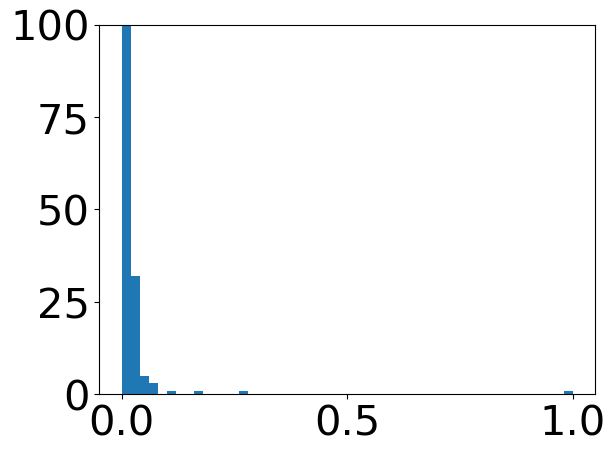

In [34]:
plt.hist(sv, bins=50)
plt.ylim(0, 100)